<a href="https://colab.research.google.com/github/tangshuting/daytoy/blob/master/nn_last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import numpy as np
from scipy import integrate
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=cuda,floatX=float32"
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
from google.colab import drive
drive.mount('/content/drive')
f = open(r'/content/drive/My Drive/EMW/2016.04C.multisnr.pkl','rb') #open的参数是pkl文件的路径
Xd = pickle.load(f,encoding='bytes')
print(type(Xd))   # dict
print(len(Xd))  #220=11（类别）×20（20个snr）
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])  # set()创建一个无序的不重复元素序列
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr)) # append末尾添加对象
X = np.vstack(X)
print(X.shape)


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
<class 'dict'>
220
(162060, 2, 128)


In [3]:
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size= int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
# changed from x to combined data
# X_train = combined_Data[train_idx]
# X_test =  combined_Data[test_idx]
X_train = X[train_idx]
X_test =  X[test_idx]
print(X_train.shape)
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods

print(Y_train[1])
print(Y_train.shape)
print(classes)

(81030, 2, 128)
(81030, 2, 128) [2, 128]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(81030, 11)
[b'8PSK', b'AM-DSB', b'AM-SSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']


In [15]:
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import keras.models as models

model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(135, activation='relu'))
model.add(Dense(11, activation='softmax'))
# model1.add(Reshape([len(classes)]))    #Error when checking target: expected dense_8 to have 4 dimensions, but got array with shape (81030, 11)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 135)               69255     
_________________________________________________________________
dense_6 (Dense)              (None, 11)                1496      
Total params: 202,335
Trainable params: 202,335
Non-trainable params: 0
________________________________________________

In [16]:
# Set up some params
nb_epoch = 100    # number of epochs to train on
batch_size = 1024  # training batch size

# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'nn.wts.h5'
history=model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_split=0.05,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)



Train on 76978 samples, validate on 4052 samples
Epoch 1/100
 - 2s - loss: 4.1492 - accuracy: 0.1701 - val_loss: 2.2472 - val_accuracy: 0.2061
Epoch 2/100
 - 2s - loss: 2.2411 - accuracy: 0.2032 - val_loss: 2.1898 - val_accuracy: 0.2093
Epoch 3/100
 - 2s - loss: 2.1864 - accuracy: 0.2134 - val_loss: 2.1514 - val_accuracy: 0.2211
Epoch 4/100
 - 2s - loss: 2.1452 - accuracy: 0.2300 - val_loss: 2.1144 - val_accuracy: 0.2579
Epoch 5/100
 - 2s - loss: 2.1031 - accuracy: 0.2630 - val_loss: 2.0709 - val_accuracy: 0.2720
Epoch 6/100
 - 2s - loss: 2.0475 - accuracy: 0.2794 - val_loss: 2.0122 - val_accuracy: 0.2831
Epoch 7/100
 - 2s - loss: 1.9771 - accuracy: 0.2877 - val_loss: 1.9513 - val_accuracy: 0.2917
Epoch 8/100
 - 2s - loss: 1.9193 - accuracy: 0.3004 - val_loss: 1.8929 - val_accuracy: 0.3164
Epoch 9/100
 - 2s - loss: 1.8609 - accuracy: 0.3163 - val_loss: 1.8266 - val_accuracy: 0.3381
Epoch 10/100
 - 2s - loss: 1.7936 - accuracy: 0.3465 - val_loss: 1.7431 - val_accuracy: 0.3746
Epoch 11/1

In [17]:
score = model.evaluate(X_test, Y_test, batch_size=batch_size)
print(model.metrics_names)
print (score)

81030/81030 [==============================] - 1s 10us/step
['loss', 'accuracy']
[1.0191417648132297, 0.6177465319633484]


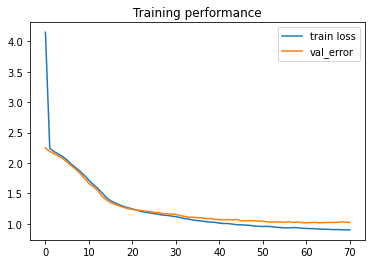

In [18]:
# Show loss curves
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

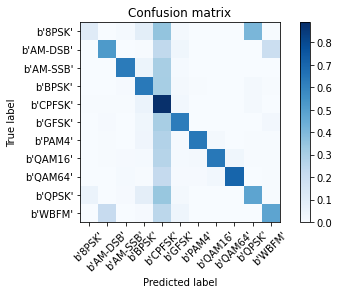

In [13]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes), len(classes)])
confnorm = np.zeros([len(classes), len(classes)])
for i in range(0, X_test.shape[0]):
    j = list(Y_test[i, :]).index(1)
    k = int(np.argmax(test_Y_hat[i, :]))
    conf[j, k] = conf[j, k] + 1
for i in range(0, len(classes)):
    confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.16000992309600595
Overall Accuracy:  0.16072745146227574
Overall Accuracy:  0.15976331360946747
Overall Accuracy:  0.16149068322981366
Overall Accuracy:  0.1652152878567973
Overall Accuracy:  0.2117039586919105
Overall Accuracy:  0.3700710262062209
Overall Accuracy:  0.5402270483711747
Overall Accuracy:  0.7336696090794451
Overall Accuracy:  0.8419235511713934
Overall Accuracy:  0.8612558947629685
Overall Accuracy:  0.8573191804492718
Overall Accuracy:  0.886159085380686
Overall Accuracy:  0.907051282051282
Overall Accuracy:  0.84413352970054
Overall Accuracy:  0.8988153998025666
Overall Accuracy:  0.9325062034739454
Overall Accuracy:  0.852054794520548
Overall Accuracy:  0.8891352549889135
Overall Accuracy:  0.9357569721115537


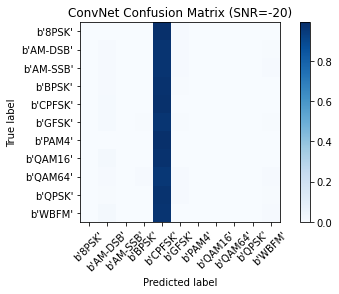

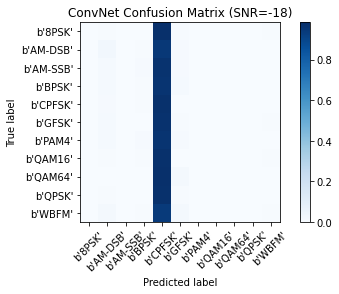

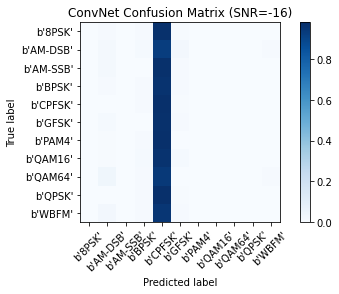

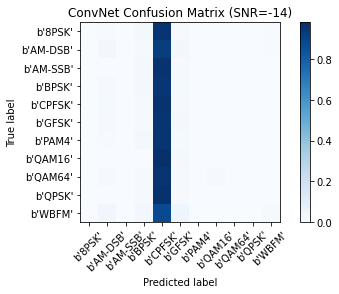

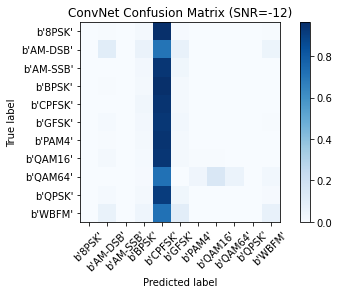

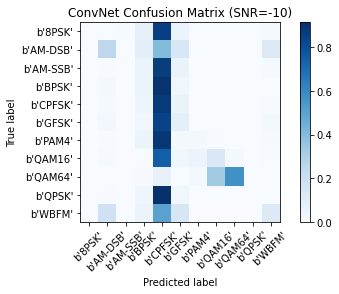

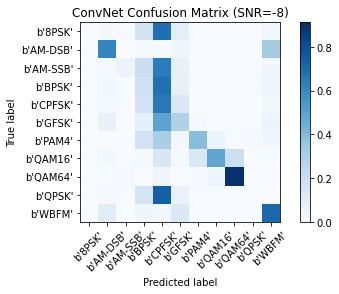

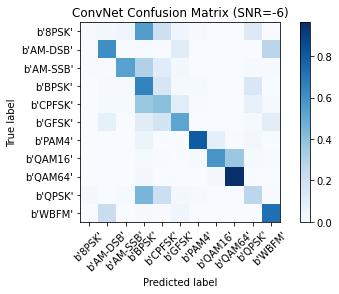

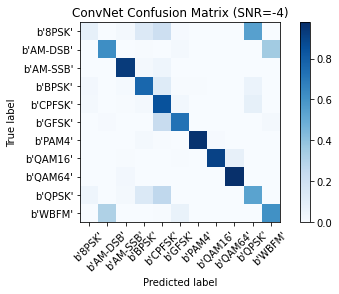

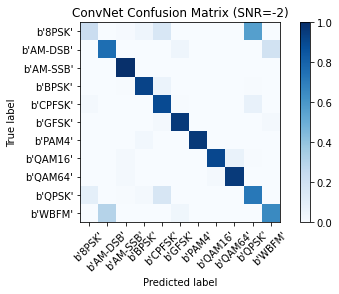

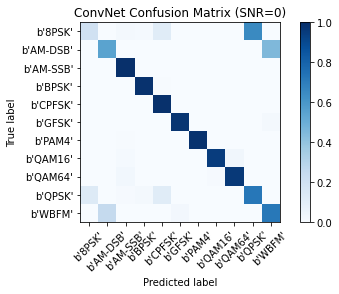

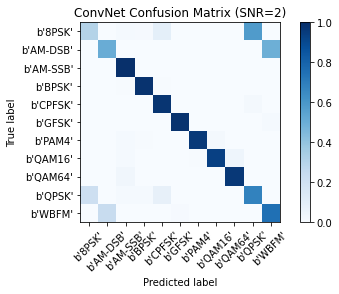

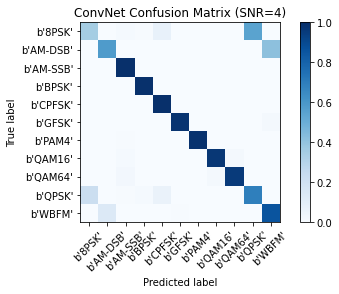

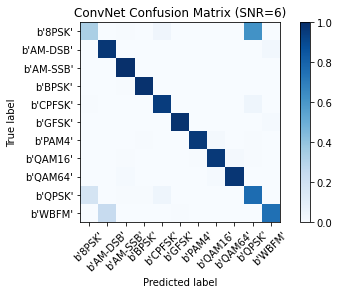

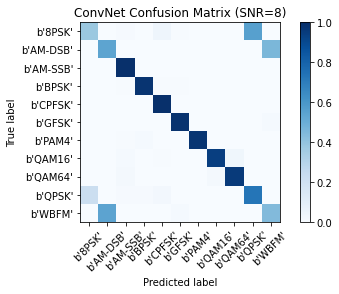

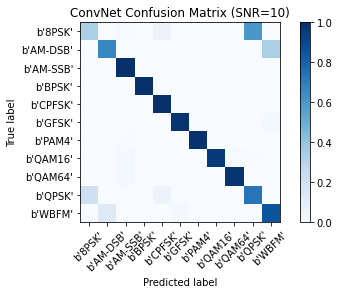

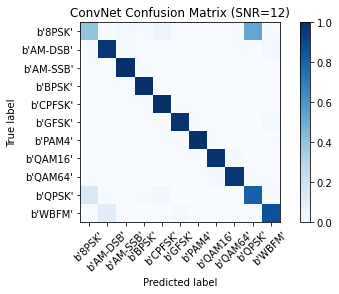

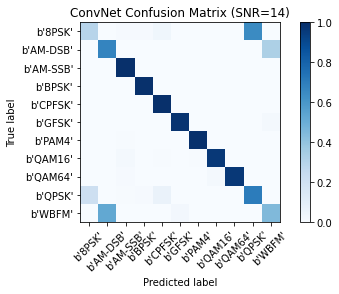

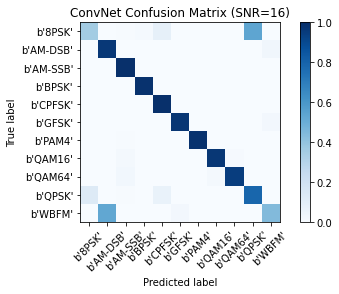

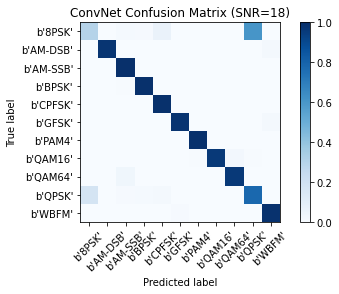

In [19]:
acc = {}
# eps = 0.2
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs) == snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs) == snr)]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])

    # loss=keras.losses.categorical_crossentropy(test_Y_i,model.output)

    # gradient=K.gradients(loss,model.input)

    # sign_grad = K.sign(gradient[0])
    # adv = test_X_i + eps*sign_grad

    for i in range(0, test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
    for i in range(0, len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)" % (snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor + ncor))
    acc[snr] = 1.0 * cor / (cor + ncor)